In [140]:
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt

# Input

In [181]:
nr_runs = 200                # Number of generated EV-behaviour runs
bid_length = 16              # [ISP] Bid block length
max_load = 20000             # [MW] Maximum load that can be transported to the network
forecast_perc_av = 0.5       # Share of forecast that is based on the average EV behaviour, the rest is based on the behaviour of the previous week
EV_compensation = 0.75       # Share of the income that is used as compensation for EV-owners
fine_factor = 10             # This factor is 10 or 20, depending on whether the non-availability has been communicated to TenneT within 12 hours after the moment of delivery. Considering the fact that strategic behaviour is excluded from this research and that BSPs are obliged to report to TenneT if they are not able to fulfill their bid, it is assumed that aggregators will always report to TenneT within 12 hours and therefor the factor will be 10. 
nr_EVs = 45000               # Number of EVs that are included in the research

# Charging properties
average_charging_speed = 11  # [kW] Average charging speed
flex_part = 0.1              # part of charging speed that is provided as flexibility 
uncertainty_buffer = 0.25     # Part of flex that will be used as buffer to cope with the uncertainty and reduce fines. (0 = no uncertainty buffer, 1 = no bids)

# Share of EVs that charge at different locations instead of parking without connecting the car to the loading station
charge_home = 0.9
charge_work = 0.5 
charge_work_visit = 0.2
charge_bringing = 0
charge_education = 0
charge_shop = 0
charge_visit = 0.05
charge_wandering = 0
charge_hobby = 0.05
charge_leisure = 0.05
charge_PC = 0
charge_other = 0
charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

In [142]:
col = ['Yearday', 'Weekday', 'Workday', 'Time', 'Home', 'Work', 'Work_Visit', 'Bringing', 'Education', 'Shop', 'Visit', 'Wandering', 'Hobby', 'Leisure', 'Personal_Care', 'Other', 'Driving_to_Home', 'Driving_to_Work', 'Driving_to_Work_Visit', 'Driving_to_Bringing', 'Driving_to_Education', 'Driving_to_Shop', 'Driving_to_Visit', 'Driving_to_Wandering', 'Driving_to_Hobby', 'Driving_to_Leisure', 'Driving_to_Personal_Care', 'Driving_to_Other']

# Import data

#### Import and prepare average mobility

In [143]:
EV_average = pd.read_csv('EV all years yearday.csv')
EV_average = EV_average[col]

# Calculate available MW for forecasting in the model
EV_average['Available MW'] = 0
counter = 0
for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
    EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
    counter += 1

#### Import FCR- and load data

In [144]:
## Import FCR-price data
FCR_prices = pd.read_csv('FCR Settlement Price.csv').drop('Unnamed: 0', axis = 1)

## Import Load data
average_load = pd.read_csv('Loaddata average.csv').drop('Unnamed: 0', axis = 1)

# Stochastic model

In [145]:
special_days = [1, 125, 359, 360]

In [146]:
def run_model(run):

    ## Import stochastic EV data
    run_EV = random.choice(runlist)   # Code for if run may not be used multiple times
    runlist.remove(run_EV)
    df = pd.read_csv(os.path.realpath('') + '\\EV runs\\Random EV ' + str(run_EV) + '.csv').drop('Unnamed: 0', axis = 1)
    
    df['Load'] = average_load['Load [MW]']
    df['Residual Load'] = max_load - df['Load']            # Residual load that is available for charging of EVs
    df['Residual Flex'] = flex_part * df['Residual Load']  # Max available capacity for flex, given the residual load on the network
    df['Residual Flex'] = df[['Residual Load', 'Residual Flex']].min(axis=1)
    df['FCR Price'] = FCR_prices['Price']
    df['Forecast'] = 0
    df['Bid Size'] = 0
    df['Available MW'] = 0

    ## Calculate Actual Available MW for every ISP
    counter = 0
    for c in df.columns[list(df.columns).index('Home'):list(df.columns).index('Other')+1]:
        df['Available MW'] = df['Available MW'] + (df[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Forecast & submit bids
    df['Forecast'] = (1 - forecast_perc_av) * df['Available MW'].shift(672) + forecast_perc_av * EV_average['Available MW']
    # Since EV-behaviour is significantly different on special days, the forecasts for special days are based on only the average mobility during the concerning special day
    for day in special_days:
        # Forecast for special days is only based on the average data, not on the behaviour of 7 days ago
        df.loc[df.Yearday == day, 'Forecast'] = EV_average['Available MW']
        # Also forecast for the day that is 7 exactly 7 days after a special day is only based on the average data, not on the behaviour during the special day.
        df.loc[df.Yearday == day + 7, 'Forecast'] = EV_average['Available MW']
    df['Forecast incl uncertainty buffer'] = df['Forecast'] * (1 - uncertainty_buffer)
    
    ## Include load limitations
    df['Forecast incl load'] = df[['Forecast incl uncertainty buffer', 'Residual Flex']].min(axis=1)
    df['Limitation'] = 'EV'
    df.loc[df['Forecast incl load'] != df['Forecast incl uncertainty buffer'], 'Limitation'] = 'Network'
    
    for t in range(672, df.shape[0], bid_length):
        df.loc[t:t+(bid_length-1), 'Bid Size'] = max(0, min(list(df.loc[t:t+(bid_length-1), 'Forecast incl load'])))
    
    ## Settlement and KPI's
    df['Fine'] = (df['Bid Size'] - df['Available MW'])
    df.loc[df.Fine < 0, 'Fine'] = 0
    df['Fine'] = df['Fine'] * fine_factor * df['FCR Price']
    df['Income'] = df['Bid Size'] * df['FCR Price']
    df['Costs'] = EV_compensation * df['Income']
    df['Profit'] = df['Income'] - df['Costs'] - df['Fine']
    
    # Save kpi's to df_output
    df = df[672:]
    df_output.loc[run, 'Average Bid [MW]'] = sum(df['Bid Size']) / len(df['Bid Size'])
    df_output.loc[run, 'Available MW'] = sum(df['Available MW']) / len(df['Available MW'])
    df_output.loc[run, 'Total Income [1000 €]'] = sum(df['Income']) / 1000
    df_output.loc[run, 'Total Costs [1000 €]'] = sum(df['Costs']) / 1000
    df_output.loc[run, 'Total Fines [1000 €]'] = sum(df['Fine']) / 1000
    df_fines = df[df['Fine'] != 0]
    df_output.loc[run, 'Number of Fines [#]'] = df_fines.shape[0]
    df_output.loc[run, 'Total Profit [1000 €]'] = sum(df['Profit']) / 1000
    df_output.loc[run, 'Number of ISPs with grid limitations [#]'] = len(df[df['Limitation'] == 'Network'])

In [177]:
nr_runs = 200
runlist = list(range(1, nr_runs+1))
df_output = pd.DataFrame()

for run in range(nr_runs):
    run_model(run)
    
# Calculate averages, max, min and standard deviations of the columns. First the values are saved in another DataFrame to prevent the average, max, min and standard deviation influencing each other
df_output2 = pd.DataFrame()

for c in df_output.columns:
    df_output2.loc['Average', c] = df_output[c].sum() / nr_runs
    df_output2.loc['Max', c] = df_output.loc[0:nr_runs-1, c].max()
    df_output2.loc['Min', c] = df_output.loc[0:nr_runs-1, c].min()
    df_output2.loc['Standard deviation', c] = df_output.loc[0:nr_runs-1, c].std()

for c in df_output.columns:
    df_output.loc['Average', c] =  df_output2.loc['Average', c]
    df_output.loc['Max', c] = df_output2.loc['Max', c]
    df_output.loc['Min', c] = df_output2.loc['Min', c]
    df_output.loc['Standard deviation', c] = df_output2.loc['Standard deviation', c]

In [187]:
print('The yearly profit for the aggregator per EV is €' + str((1000 * df_output.loc['Average', 'Total Profit [1000 €]'] / nr_EVs).round(2)))
print('The yearly profit for an EV owner is €' + str((1000 * df_output.loc['Average', 'Total Profit [1000 €]'] / nr_EVs * (EV_compensation / (1-EV_compensation))).round(2)))

The yearly profit for the aggregator per EV is €17.8
The yearly profit for an EV owner is €53.4


In [178]:
df_output = df_output[['Average Bid [MW]', 'Number of Fines [#]', 'Total Profit [1000 €]', 'Number of ISPs with grid limitations [#]']]

df_output.loc['Average':'Min', 'Average Bid [MW]'] = df_output.loc['Average':'Min', 'Average Bid [MW]'].round(2)
df_output.loc['Standard deviation', 'Average Bid [MW]':'Total Profit [1000 €]'] = df_output.loc['Standard deviation', 'Average Bid [MW]':'Total Profit [1000 €]'].round(3)
df_output.loc['Average':'Min', 'Total Profit [1000 €]':'Total Profit [1000 €]'] = df_output.loc['Average':'Min', 'Total Profit [1000 €]':'Total Profit [1000 €]'].round()

In [180]:
df_output.loc['Average':'Standard deviation', :].astype(object)

,Average Bid [MW],Number of Fines [#],Total Profit [1000 €],Number of ISPs with grid limitations [#]
Average,26.17,9.6,801,0
Max,26.19,22,801,0
Min,26.16,1,801,0
Standard deviation,0.015,8.142,0.293,0


### Visualize daily pattern of available MW

In [10]:
df_average = pd.DataFrame(0, index = range(35040), columns = ['Average Available MW'])

for run_EV in range(1, nr_runs+1):
    df = pd.read_csv(os.path.realpath('') + '\\EV runs\\Random EV ' + str(run_EV) + '.csv').drop('Unnamed: 0', axis = 1)
    
    df['Available MW'] = 0
    counter = 0
    for c in df.columns[list(df.columns).index('Home'):list(df.columns).index('Other')+1]:
        df['Available MW'] = df['Available MW'] + (df[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    df_average['Average Available MW'] = df_average['Average Available MW'] + df['Available MW']

df_average['Average Available MW'] = df_average['Average Available MW'] / nr_runs

df_average2 = pd.DataFrame()
df_average2['Time'] = ['00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45']

for i in range(96):
    df_time_step = df_average[df_average.index % 96 == i]
    df_average2.loc[i, 'Average Available MW'] = df_time_step['Average Available MW'].sum() / len(df_time_step['Average Available MW'])

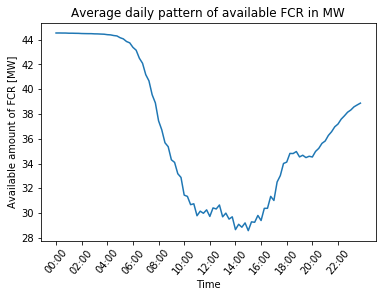

In [46]:
x = df_average2['Time']
y = df_average2['Average Available MW']
plt.plot(x, y)
plt.xticks(np.arange(0, 96, 8), rotation = 50)
# plt.yticks(np.arange(0, 45, 5))
plt.xlabel('Time') 
plt.ylabel('Available amount of FCR [MW]') 
plt.title('Average daily pattern of available FCR in MW') 
plt.savefig('Average daily pattern of available FCR in MW')
plt.show()

# Calculate the desired uncertainty buffer

In [74]:
def calculate_output(unc_buf):

    for run in range(nr_runs):
        run_model(run)
    
    # Calculate average, max, min and standard deviations of the columns. First the values are saved in another DataFrame to prevent the average, max, min and standard deviation influencing each other
    for c in df_output.columns:
        df_output2.loc['Average', c] = df_output[c].sum() / nr_runs
        df_output2.loc['Max', c] = df_output[c].max()
        df_output2.loc['Min', c] = df_output[c].min()
        df_output2.loc['Standard deviation', c] = df_output[c].std()
        
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output2.loc['Average', c]
        df_output.loc['Max', c] = df_output2.loc['Max', c]
        df_output.loc['Min', c] = df_output2.loc['Min', c]
        df_output.loc['Standard deviation', c] = df_output2.loc['Standard deviation', c]
    
    # Save data to df_ub_average, df_ub_stdev, df_ub_max, df_ub_min
    df_ub_average.loc[uncertainty_buffer, 'Average Bid [MW]'] = df_output.loc['Average', 'Average Bid [MW]']
    df_ub_average.loc[uncertainty_buffer, 'Number of Fines [#]'] = df_output.loc['Average', 'Number of Fines [#]']
    df_ub_average.loc[uncertainty_buffer, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_ub_average.loc[uncertainty_buffer, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']
    
    df_ub_stdev.loc[uncertainty_buffer, 'Average Bid [MW]'] = df_output.loc['Standard deviation', 'Average Bid [MW]']
    df_ub_stdev.loc[uncertainty_buffer, 'Number of Fines [#]'] = df_output.loc['Standard deviation', 'Number of Fines [#]']
    df_ub_stdev.loc[uncertainty_buffer, 'Total Profit [1000 €]'] = df_output.loc['Standard deviation', 'Total Profit [1000 €]']
    df_ub_stdev.loc[uncertainty_buffer, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Standard deviation', 'Number of ISPs with grid limitations [#]']
    
    df_ub_max.loc[uncertainty_buffer, 'Average Bid [MW]'] = df_output.loc['Max', 'Average Bid [MW]']
    df_ub_max.loc[uncertainty_buffer, 'Number of Fines [#]'] = df_output.loc['Max', 'Number of Fines [#]']
    df_ub_max.loc[uncertainty_buffer, 'Total Profit [1000 €]'] = df_output.loc['Max', 'Total Profit [1000 €]']
    df_ub_max.loc[uncertainty_buffer, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Max', 'Number of ISPs with grid limitations [#]']
    
    df_ub_min.loc[uncertainty_buffer, 'Average Bid [MW]'] = df_output.loc['Min', 'Average Bid [MW]']
    df_ub_min.loc[uncertainty_buffer, 'Number of Fines [#]'] = df_output.loc['Min', 'Number of Fines [#]']
    df_ub_min.loc[uncertainty_buffer, 'Total Profit [1000 €]'] = df_output.loc['Min', 'Total Profit [1000 €]']
    df_ub_min.loc[uncertainty_buffer, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Min', 'Number of ISPs with grid limitations [#]']

In [62]:
# Takes around 10 hours to run with an uncertainty buffer varying from 0 to 1 with steps of 0.01

df_output = pd.DataFrame()

# Define DataFrames in which the data is saved
df_ub_average = pd.DataFrame()
df_ub_stdev = pd.DataFrame()
df_ub_max = pd.DataFrame()
df_ub_min = pd.DataFrame()

nr_runs = 200

# Run the model
for unc_buf in range(0, 101):
    print(unc_buf / 100)
    uncertainty_buffer = unc_buf / 100
    runlist = list(range(1, nr_runs+1))
    df_output = pd.DataFrame()
    calculate_output(uncertainty_buffer)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


In [148]:
# Round the values in the columns to improve readability of the outcomes

df_ub_average['Average Bid [MW]'] = df_ub_average['Average Bid [MW]'].round(2)
df_ub_average['Number of Fines [#]'] = df_ub_average['Number of Fines [#]'].round(3)
for i in df_ub_average.index:
    if df_ub_average.loc[i, 'Number of Fines [#]'] > 1000:
        df_ub_average.loc[i, 'Number of Fines [#]'] = round(df_ub_average.loc[i, 'Number of Fines [#]'])
    if df_ub_average.loc[i, 'Number of Fines [#]'] > 100:
        df_ub_average.loc[i, 'Number of Fines [#]'] = round(df_ub_average.loc[i, 'Number of Fines [#]'], 1)
    if df_ub_average.loc[i, 'Number of Fines [#]'] > 10:
        df_ub_average.loc[i, 'Number of Fines [#]'] = round(df_ub_average.loc[i, 'Number of Fines [#]'], 2)
df_ub_average['Number of Fines [#]'] = df_ub_average['Number of Fines [#]'].astype(object)
df_ub_average['Total Profit [1000 €]'] = df_ub_average['Total Profit [1000 €]'].astype(int)
df_ub_average['Number of ISPs with grid limitations [#]'] = df_ub_average['Number of ISPs with grid limitations [#]'].astype(int)

In [64]:
# Save the average, standard deviation, maximum and minimum values of the KPIs under different uncertainty buffers

df_ub_average.to_csv('Average under different uncertainty buffers.csv')
df_ub_stdev.to_csv('Standard deviation under different uncertainty buffers.csv')
df_ub_max.to_csv('Max under different uncertainty buffers.csv')
df_ub_min.to_csv('Min under different uncertainty buffers.csv')

In [72]:
df_ub_average[:0.30]

,Average Bid [MW],Number of Fines [#],Total Profit [1000 €],Number of ISPs with grid limitations [#]
0.00,34.89,8406,584,0
0.01,34.54,6739,660,0
0.02,34.20,5719,721,0
0.03,33.85,4871,770,0
0.04,33.50,4118,810,0
0.05,33.15,3448,842,0
0.06,32.80,2856,867,0
0.07,32.45,2340,885,0
0.08,32.10,1896,898,0
0.09,31.75,1518,907,0


In [146]:
# df_ub_average = pd.read_csv('Average under different uncertainty buffers.csv')
# df_ub_average = df_ub_average.set_index('Unnamed: 0')
# del df_ub_average.index.name

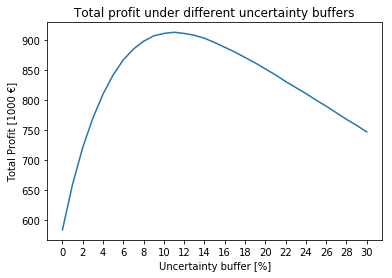

In [161]:
x = df_ub_average.index[:31] * 100
y = list(df_ub_average['Total Profit [1000 €]'])[0:31]
plt.plot(x, y)
plt.xticks(np.arange(0, 31, 2))
# plt.yticks(np.arange(0, 45, 5))
plt.xlabel('Uncertainty buffer [%]') 
plt.ylabel('Total Profit [1000 €]') 
plt.title('Total profit under different uncertainty buffers') 
plt.savefig('Total profit in 1000 € under different uncertainty buffers')
plt.show()

# Varying bid length

### Difference available MW and bid size

In [85]:
df_difference_bidlength = pd.DataFrame()

# Add average MW and bid size from model without uncertainty
df_deterministic = pd.read_csv('Output deterministic model.csv')
df_difference_bidlength.loc['Model without uncertainty', 'Average Available amount of FCR'] = df_deterministic.loc[0, 'Average Available MW']
df_difference_bidlength.loc['Model without uncertainty', 'Average Bid Size'] = df_deterministic.loc[0, 'Average Bid [MW]']

# Add average MW and bid size from model with uncertainty
uncertainty_buffer = 0.25
bid_length = 16
runlist = list(range(1, nr_runs+1))
df_output = pd.DataFrame()

for run in range(nr_runs):
    run_model(run)

df_difference_bidlength.loc['Model with uncertainty', 'Average Available amount of FCR'] = (1 - uncertainty_buffer) * df_output['Available MW'].sum() / nr_runs
df_difference_bidlength.loc['Model with uncertainty', 'Average Bid Size'] = df_output['Average Bid [MW]'].sum() / nr_runs

df_difference_bidlength.round(2)

,Average Available amount of FCR,Average Bid Size
Model without uncertainty,37.69,35.73
Model with uncertainty,27.44,26.17


### Varying bid length

In [253]:
bid_length_list = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 96]
nr_runs = 200

# df_bl_average = pd.DataFrame()
# df_bl_stdev = pd.DataFrame()
# df_bl_max = pd.DataFrame()
# df_bl_min = pd.DataFrame()

for bl in bid_length_list:
    bid_length = bl
    print(bid_length)
    
    for ub in list(range(235, 275, 5)):
        uncertainty_buffer = ub / 1000
        
        df_output = pd.DataFrame()
        runlist = list(range(1, nr_runs+1))
        for run in range(nr_runs):
            run_model(run)
    
        # Calculate averages of the columns    
        for c in df_output.columns:
            df_output.loc['Average', c] = df_output[c].sum() / nr_runs
            df_output.loc['Max', c] = df_output[c].max()
            df_output.loc['Min', c] = df_output[c].min()
            df_output.loc['Standard deviation', c] = df_output[c].std()
        
        # Save data to df_bl_average, df_bl_stdev, df_bl_max, df_bl_min
        df_bl_average.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Average Bid [MW]'] = df_output.loc['Average', 'Average Bid [MW]']
        df_bl_average.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of Fines [#]'] = df_output.loc['Average', 'Number of Fines [#]']
        df_bl_average.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
        df_bl_average.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']
        
        df_bl_stdev.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Average Bid [MW]'] = df_output.loc['Standard deviation', 'Average Bid [MW]']
        df_bl_stdev.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of Fines [#]'] = df_output.loc['Standard deviation', 'Number of Fines [#]']
        df_bl_stdev.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Total Profit [1000 €]'] = df_output.loc['Standard deviation', 'Total Profit [1000 €]']
        df_bl_stdev.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of ISPs with grid limitations [#]'] = df_output.loc['Standard deviation', 'Number of ISPs with grid limitations [#]']
        
        df_bl_max.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Average Bid [MW]'] = df_output.loc['Max', 'Average Bid [MW]']
        df_bl_max.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of Fines [#]'] = df_output.loc['Max', 'Number of Fines [#]']
        df_bl_max.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Total Profit [1000 €]'] = df_output.loc['Max', 'Total Profit [1000 €]']
        df_bl_max.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of ISPs with grid limitations [#]'] = df_output.loc['Max', 'Number of ISPs with grid limitations [#]']
        
        df_bl_min.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Average Bid [MW]'] = df_output.loc['Min', 'Average Bid [MW]']
        df_bl_min.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of Fines [#]'] = df_output.loc['Min', 'Number of Fines [#]']
        df_bl_min.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Total Profit [1000 €]'] = df_output.loc['Min', 'Total Profit [1000 €]']
        df_bl_min.loc[str(bid_length) + ', ' + str(uncertainty_buffer), 'Number of ISPs with grid limitations [#]'] = df_output.loc['Min', 'Number of ISPs with grid limitations [#]']

1
2
3
4
6
8
12
16
24
32
48
96


In [254]:
df_bl_average = df_bl_average.sort_index(axis = 0, ascending=True)
df_bl_stdev = df_bl_stdev.sort_index(axis = 0, ascending=True)
df_bl_max = df_bl_max.sort_index(axis = 0, ascending=True)
df_bl_min = df_bl_min.sort_index(axis = 0, ascending=True)

In [258]:
# df_bl_average.to_csv('Average under different bid lengths per 0.5 %.csv')
# df_bl_stdev.to_csv('Standard deviation under different bid lengths per 0.5 %.csv')
# df_bl_max.to_csv('Max under different bid lengths per 0.5 %.csv')
# df_bl_min.to_csv('Min under different bid lengths per 0.5 %.csv')

In [108]:
# df_bl_average = pd.read_csv('Average under different bid lengths per 0.5 %.csv').set_index('Unnamed: 0').rename(columns={'Number of ISPs with grid limitations': 'Number of ISPs with grid limitations [#]'})
# df_bl_stdev = pd.read_csv('Standard deviation under different bid lengths per 0.5 %.csv').set_index('Unnamed: 0')
# df_bl_max = pd.read_csv('Max under different bid lengths per 0.5 %.csv').set_index('Unnamed: 0')
# df_bl_min = pd.read_csv('Min under different bid lengths per 0.5 %.csv').set_index('Unnamed: 0')
# del df_bl_average.index.name

In [109]:
fines_under_bidlength = pd.DataFrame()

for bid in bid_length_list:
    for buffer in range(230, 280, 5):
        buffer2 = buffer / 1000
        fines_under_bidlength.loc[buffer2, bid] = df_bl_average.loc[str(bid) + ', ' + str(buffer2), 'Number of Fines [#]']

In [125]:
fines_under_bidlength = fines_under_bidlength[0.235:].round(2)

In [120]:
fines_under_bidlength.to_csv('Fines under different bid lengths per 0.5 %.csv')

In [126]:
def color_cells(x):
    color = 'background-color: lightgreen'
    df1 = pd.DataFrame('', index = x.index, columns = x.columns)
    df1.iloc[8, 0] = color
    df1.iloc[7, 1] = color
    df1.iloc[6, 2] = color
    df1.iloc[6, 3] = color
    df1.iloc[5, 4] = color
    df1.iloc[4, 5] = color
    df1.iloc[3, 6] = color
    df1.iloc[3, 7] = color
    df1.iloc[2, 8] = color
    df1.iloc[2, 9] = color
    df1.iloc[2, 10] = color
    df1.iloc[0, 11] = color
    return df1

In [127]:
df_color = fines_under_bidlength.style.apply(color_cells, axis = None)

In [128]:
df_color

,1,2,3,4,6,8,12,16,24,32,48,96
0.235,46.7,39.83,34.46,31.52,27.04,23.32,19.78,18.07,15.53,13.96,14.09,10.89
0.24,38.74,32.8,28.38,25.96,22.24,19.2,16.28,14.94,12.75,11.78,11.6,9.14
0.245,31.86,27.1,23.54,21.44,18.36,15.87,13.59,12.34,10.58,9.74,9.6,7.57
0.25,26.03,22.1,19.22,17.42,14.94,12.9,11.01,10.12,8.59,8.01,7.85,6.21
0.255,21.4,18.03,15.78,14.42,12.34,10.74,9.12,8.48,7.19,6.74,6.62,5.27
0.26,17.84,15.12,13.02,12.09,10.28,8.99,7.57,7.12,5.94,5.72,5.5,4.39
0.265,14.54,12.29,10.7,9.82,8.46,7.28,6.24,5.78,4.84,4.7,4.52,3.66
0.27,11.96,10.12,8.78,8.2,6.92,6.14,5.14,4.82,3.98,3.95,3.72,3.06
0.275,9.98,8.42,7.18,6.71,5.61,5.02,4.14,3.94,3.2,3.28,3.04,2.55


In [115]:
combination_list = ['1, 0.275', '2, 0.27', '3, 0.265', '4, 0.265', '6, 0.26', '8, 0.255', '12, 0.25', '16, 0.25', '24, 0.245', '32, 0.245', '48, 0.245', '96, 0.235']

In [116]:
df_bl_average.loc[df_bl_average.index.isin(combination_list)]
df_bl_average = df_bl_average.reindex(combination_list)
df_bl_average['Average Bid [MW]'] = df_bl_average['Average Bid [MW]'].round(2)
df_bl_average['Number of Fines [#]'] = df_bl_average['Number of Fines [#]'].round(1)
df_bl_average['Total Profit [1000 €]'] = df_bl_average['Total Profit [1000 €]'].round()
df_bl_average['Number of ISPs with grid limitations [#]'] = df_bl_average['Number of ISPs with grid limitations [#]'].round()

In [118]:
df_bl_average.astype(object)

,Average Bid [MW],Number of Fines [#],Total Profit [1000 €],Number of ISPs with grid limitations [#]
"1, 0.275",26.93,10,824,0
"2, 0.27",26.99,10.1,826,0
"3, 0.265",27.04,10.7,827,0
"4, 0.265",26.95,9.8,824,0
"6, 0.26",26.92,10.3,824,0
"8, 0.255",26.93,10.7,824,0
"12, 0.25",26.71,11,817,0
"16, 0.25",26.17,10.1,801,0
"24, 0.245",26.08,10.6,798,0
"32, 0.245",24.86,9.7,761,0


# Verification: Sensitivity analysis

In [47]:
# Define the variations in the variables that will be made
uncertainty_buffer_list = [0.25, 0, 1, -100]
flex_part_list = [0.1, 0, 1, 100]
EV_compensation_list = [0.75, 0, 1, 10]
fine_factor_list = [10, 0, 1000, -10]
tendency_to_charge_factor_list = [1, 0, 100, -100]
max_load_list = [20000, 0, 1000000, -1000000]

In [49]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in uncertainty_buffer_list:    
    
    uncertainty_buffer = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[uncertainty_buffer, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[uncertainty_buffer, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[uncertainty_buffer, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[uncertainty_buffer, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis uncertainty_buffer.csv')

In [53]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
0.25,26.17,800,10.67,0
0.00,34.89,584,8409.67,0
1.00,0,0,0,0
-100.00,735.6,-847598,34368,34368


In [54]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in flex_part_list:    
    
    flex_part = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[flex_part, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[flex_part, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[flex_part, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[flex_part, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis flex_part.csv')

In [55]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
0.1,26.17,800,10.27,0
0.0,0,0,0,0
1.0,261.64,8003,11.57,0
100.0,7355.99,228816,0,34368


In [56]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in EV_compensation_list:    
    
    EV_compensation = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[EV_compensation, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[EV_compensation, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[EV_compensation, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[EV_compensation, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis EV_compensation.csv')

In [57]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
0.75,26.17,800,10.13,0
0.00,26.17,3203,10.03,0
1.00,26.17,0,10.47,0
10.00,26.17,-28833,11.37,0


In [58]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in fine_factor_list:    
    
    fine_factor = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[fine_factor, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[fine_factor, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[fine_factor, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[fine_factor, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis fine_factor.csv')

In [59]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
10,26.17,800,10.23,0
0,26.17,800,0,0
1000,26.17,782,7.9,0
-10,26.17,801,9.7,0


In [60]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in tendency_to_charge_factor_list:    
    
    tendency_to_charge_factor = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[tendency_to_charge_factor, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[tendency_to_charge_factor, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[tendency_to_charge_factor, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[tendency_to_charge_factor, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis tendency_to_charge_factor.csv')

In [61]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
1,26.17,800,11.17,0
0,0,0,0,0
100,735.6,22881,0,34368
-100,0,-4475864,34368,0


In [62]:
# Reset variables to default value
uncertainty_buffer = 0.25
flex_part = 0.1
EV_compensation = 0.75
fine_factor = 10
tendency_to_charge_factor = 1
max_load = 20000

nr_modelruns = 30
df_table = pd.DataFrame()

for f in max_load_list:    
    
    max_load = f
    
    ## This part of the code below is to make sure the changes in the input-parameters are used where they need to be in the model

    # Recalculate the tendencies to charge at the twelve different types of locations
    charge_home = 0.9 * tendency_to_charge_factor
    charge_work = 0.5  * tendency_to_charge_factor
    charge_work_visit = 0.2 * tendency_to_charge_factor
    charge_bringing = 0 * tendency_to_charge_factor
    charge_education = 0 * tendency_to_charge_factor
    charge_shop = 0 * tendency_to_charge_factor
    charge_visit = 0.05 * tendency_to_charge_factor
    charge_wandering = 0 * tendency_to_charge_factor
    charge_hobby = 0.05 * tendency_to_charge_factor
    charge_leisure = 0.05 * tendency_to_charge_factor
    charge_PC = 0 * tendency_to_charge_factor
    charge_other = 0 * tendency_to_charge_factor
    charge_list = [charge_home, charge_work, charge_work_visit, charge_bringing, charge_education, charge_shop, charge_visit, charge_wandering, charge_hobby, charge_leisure, charge_PC, charge_other]

    # Adjust average mobility outcomes (for if tendency to charge factor is adjusted)
    EV_average = pd.read_csv('EV all years yearday.csv')
    EV_average = EV_average[col]
    
    # Calculate available MW for forecasting in the model
    EV_average['Available MW'] = 0
    counter = 0
    for c in EV_average.columns[list(EV_average.columns).index('Home'):list(EV_average.columns).index('Other')+1]:
        EV_average['Available MW'] = EV_average['Available MW'] + (EV_average[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    ## Prepare input and run the model
    df_output = pd.DataFrame()
    runlist = list(range(1, nr_runs))
    
    for run in range(nr_modelruns):
        run_model(run)
    
    # Calculate averages of the columns    
    for c in df_output.columns:
        df_output.loc['Average', c] = df_output[c].sum() / nr_modelruns
    
    df_output.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis with input ' + str(uncertainty_buffer) + ', ' + str(flex_part) + ', ' + str(EV_compensation) + ', ' + str(fine_factor) + ', ' + str(tendency_to_charge_factor) + ', ' + str(max_load) + '.csv')
    
    df_output = df_output[['Average Bid [MW]', 'Total Profit [1000 €]', 'Number of Fines [#]', 'Number of ISPs with grid limitations [#]']]
    
    df_table.loc[max_load, 'Average Bid [MW]'] = round(df_output.loc['Average', 'Average Bid [MW]'], 2)
    df_table.loc[max_load, 'Total Profit [1000 €]'] = df_output.loc['Average', 'Total Profit [1000 €]']
    df_table.loc[max_load, 'Number of Fines [#]'] = round(df_output.loc['Average', 'Number of Fines [#]'], 2)
    df_table.loc[max_load, 'Number of ISPs with grid limitations [#]'] = df_output.loc['Average', 'Number of ISPs with grid limitations [#]']

df_table['Total Profit [1000 €]'] = df_table['Total Profit [1000 €]'].astype(int)
df_table['Number of ISPs with grid limitations [#]'] = df_table['Number of ISPs with grid limitations [#]'].astype(int)

df_table.to_csv(os.path.realpath('') + '\\Runs sensitivity analysis\\Sensitivity analysis max_load.csv')

In [63]:
df_table.astype(object)

,Average Bid [MW],Total Profit [1000 €],Number of Fines [#],Number of ISPs with grid limitations [#]
20000,26.17,800,9.8,0
0,0,0,0,34368
1000000,26.17,800,8.17,0
-1000000,0,0,0,34368


# Validation: Comparison between model with and without uncertainty

In [43]:
df_compare = pd.DataFrame(index = range(35040))
df_compare['Average amount of FCR with uncertainty [MW]'] = 0

# Calculate the average amount of available FCR in MW in the 200 runs of EV movements
for run in range(1, nr_runs+1):
    df_run = pd.read_csv(os.path.realpath('') + '\\EV runs\\Random EV ' + str(run) + '.csv').drop('Unnamed: 0', axis = 1)
    df_run['Available MW'] = 0
    counter = 0
    
    for c in df_run.columns[list(df_run.columns).index('Home'):list(df_run.columns).index('Other')+1]:
        df_run['Available MW'] = df_run['Available MW'] + (df_run[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
        counter += 1
    
    df_compare['Average amount of FCR with uncertainty [MW]'] = df_compare['Average amount of FCR with uncertainty [MW]'] + df_run['Available MW']
    
df_compare['Average amount of FCR with uncertainty [MW]'] = df_compare['Average amount of FCR with uncertainty [MW]'] / nr_runs

In [44]:
df_deterministic = pd.read_csv('EV all years yearday.csv')
df_deterministic = df_deterministic[col]

# Calculate available MW for forecasting in the model
df_deterministic['Available MW'] = 0

counter = 0
for c in df_deterministic.columns[list(df_deterministic.columns).index('Home'):list(df_deterministic.columns).index('Other')+1]:
    df_deterministic['Available MW'] = df_deterministic['Available MW'] + (df_deterministic[c] * charge_list[counter] * average_charging_speed * flex_part / 1000)
    counter += 1

In [45]:
df_compare['Average amount of FCR without uncertainty [MW]'] = df_deterministic['Available MW']

for c in df_compare.columns:
    df_compare.loc['Average', c] = df_compare[c].sum() / df_compare.shape[0]
    
df_compare = df_compare[['Average amount of FCR with uncertainty [MW]', 'Average amount of FCR without uncertainty [MW]']]

In [46]:
df_compare.to_csv('Validation. Compare average available amount of FCR.csv')
df_compare['Average':].round(2)

,Average amount of FCR with uncertainty [MW],Average amount of FCR without uncertainty [MW]
Average,36.6,37.7
